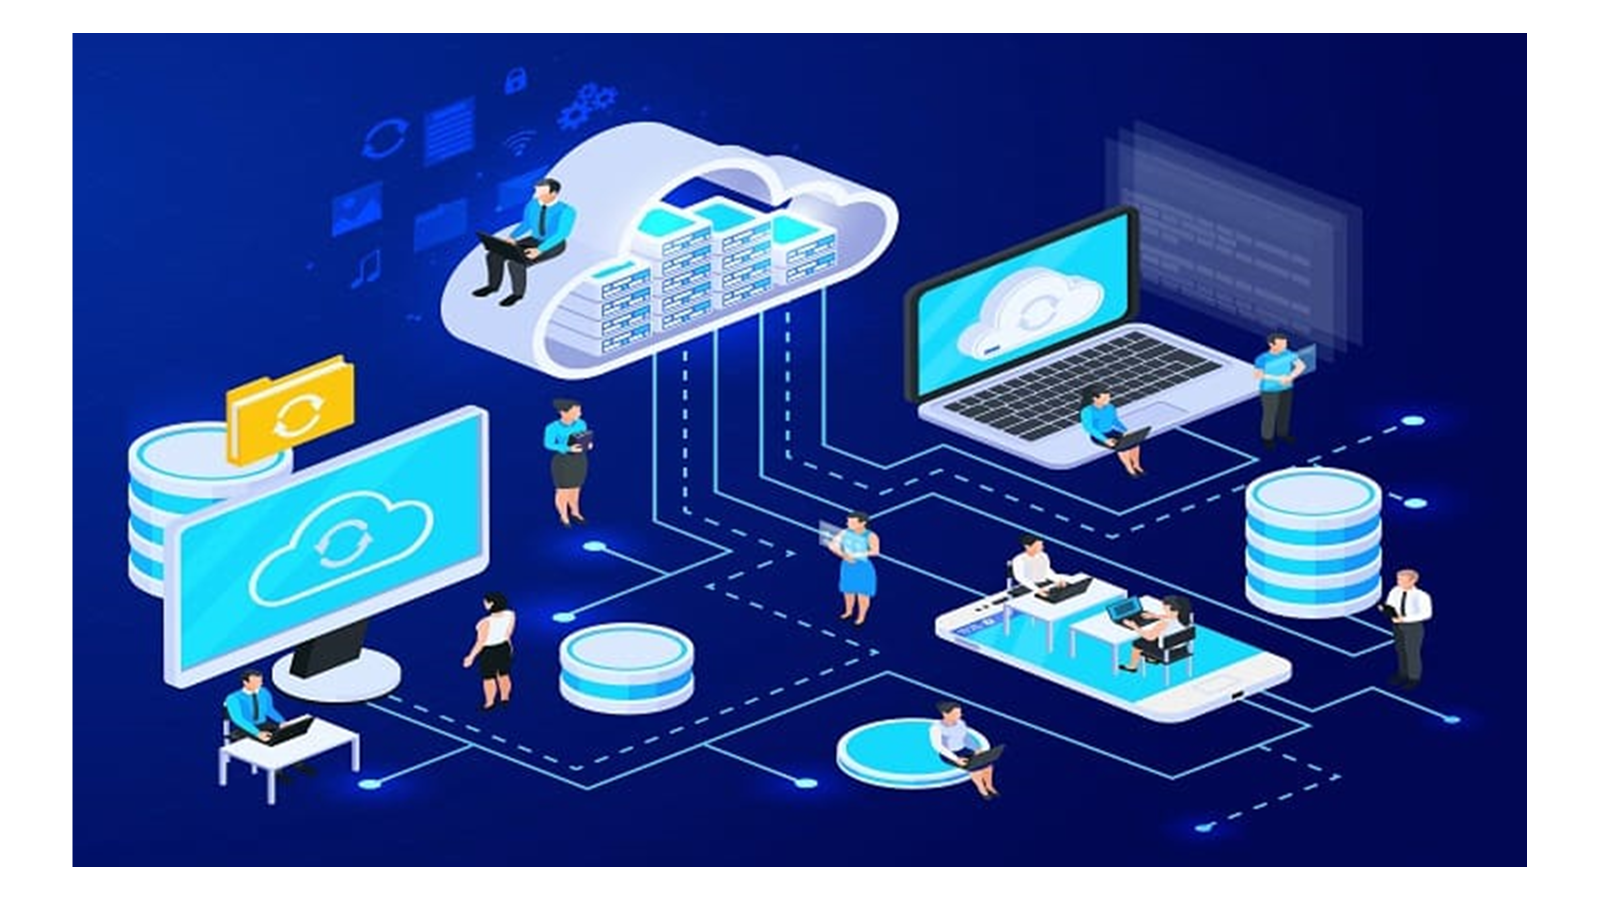

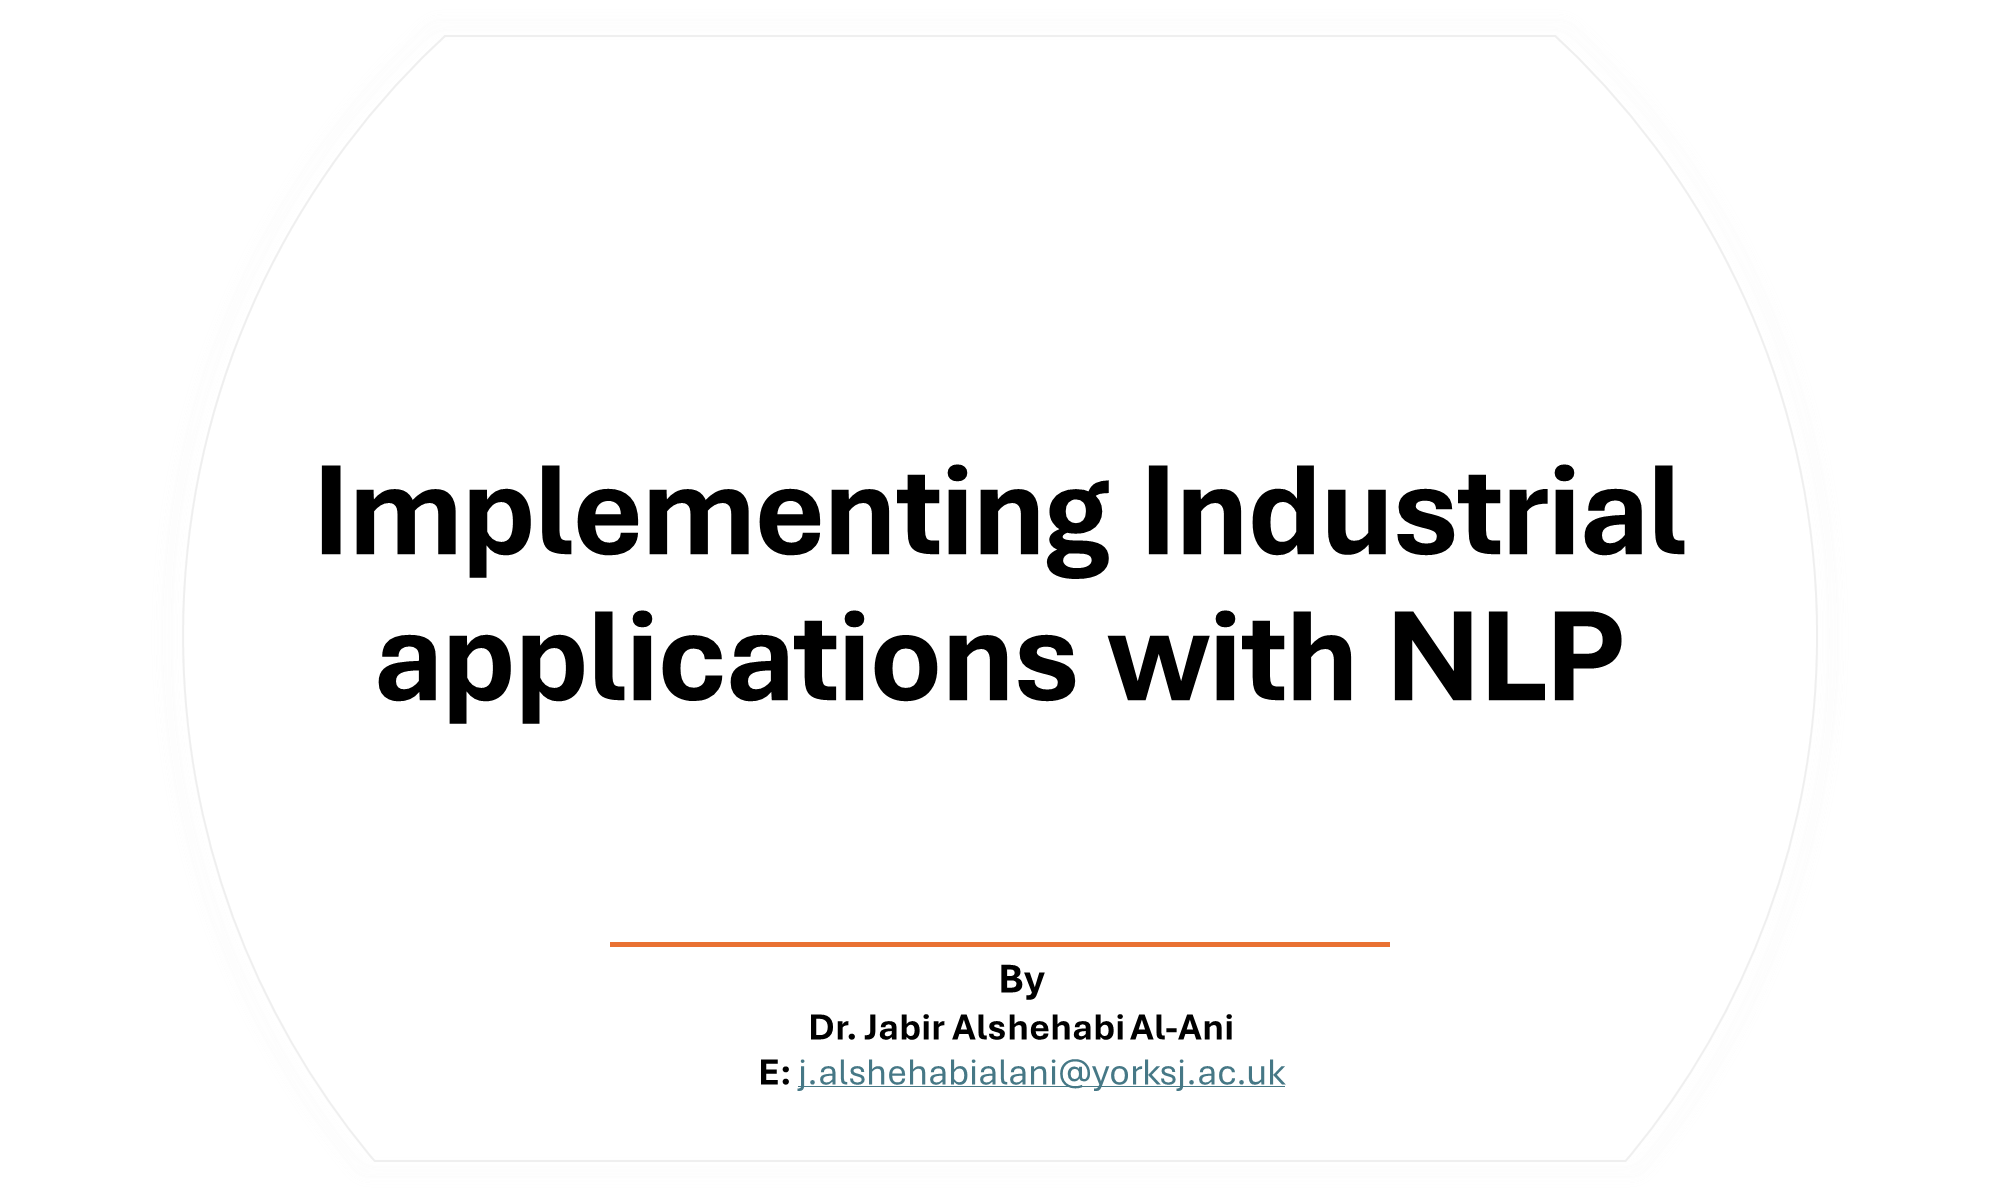

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
#ON_COLAB = 'google.colab' in sys.modules

#if ON_COLAB:
#    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
#    os.system(f'wget {GIT_ROOT}/ch09/setup.py')

#%run -i setup.py

## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [2]:
%run "settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# path to import blueprints packages
sys.path.append('/packages')

In [3]:
# adjust matplotlib resolution for book version
matplotlib.rcParams.update({'figure.dpi': 200 })

In [4]:
from rouge_score import rouge_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import tokenize
import matplotlib.pyplot as plt
import html
import re
import random
import rouge_score
import wikipediaapi

ModuleNotFoundError: No module named 'rouge_score'

# How to create short summaries of long textual information for quick reading

# Text Summarization

## Extractive Methods


## Data pre-processing 


In [5]:
import requests
from bs4 import BeautifulSoup
import os.path
from dateutil import parser
import pandas as pd
import numpy as np

In [6]:
def download_article(url):
    # check if article already there
    filename = url.split("/")[-1] + ".html"
    filename = f"" + filename
    if not os.path.isfile(filename):
        r = requests.get(url)
        with open(filename, "w+") as f:
            f.write(r.text)
    return filename

In [7]:
def parse_article(article_file):
    with open(article_file, "r") as f:
        html = f.read()
    r = {}
    soup = BeautifulSoup(html, 'html.parser')
    r['id'] = soup.select_one("div.StandardArticle_inner-container")['id']
    r['url'] = soup.find("link", {'rel': 'canonical'})['href']
    r['headline'] = soup.h1.text
    r['section'] = soup.select_one("div.ArticleHeader_channel a").text
    
    r['text'] = soup.select_one("div.StandardArticleBody_body").text
    r['authors'] = [a.text 
                    for a in soup.select("div.BylineBar_first-container.ArticleHeader_byline-bar\
                                          div.BylineBar_byline span")]
    r['time'] = soup.find("meta", { 'property': "og:article:published_time"})['content']
    return r

In [9]:
import reprlib
r = reprlib.Repr()
r.maxstring = 800

url1 = "https://www.reuters.com/article/us-qualcomm-m-a-broadcom-5g/what-is-5g-and-who-are-the-major-players-idUSKCN1GR1IN"
#url1 = "https://www.bbc.co.uk/news/in-pictures-68942528"

article_name1 = download_article(url1)
article1 = parse_article(article_name1)
print ('Article Published on', r.repr(article1['time']))
print (r.repr(article1['text']))

Article Published on '2018-03-15T11:36:28+0000'
'LONDON/SAN FRANCISCO (Reuters) - U.S. President Donald Trump has blocked microchip maker Broadcom Ltd’s (AVGO.O) $117 billion takeover of rival Qualcomm (QCOM.O) amid concerns that it would give China the upper hand in the next generation of mobile communications, or 5G. A 5G sign is seen at the Mobile World Congress in Barcelona, Spain February 28, 2018. REUTERS/Yves HermanBelow are some facts... 4G wireless and looks set to top the list of patent holders heading into the 5G cycle. Huawei, Nokia, Ericsson and others are also vying to amass 5G patents, which has helped spur complex cross-licensing agreements like the deal struck late last year Nokia and Huawei around handsets. Editing by Kim Miyoung in Singapore and Jason Neely in LondonOur Standards:The Thomson Reuters Trust Principles.'


# Blueprint - Summarizing text using topic representation

## Identifying important words with TF-IDF values


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import tokenize

sentences = tokenize.sent_tokenize(article1['text'])
tfidfVectorizer = TfidfVectorizer()
words_tfidf = tfidfVectorizer.fit_transform(sentences)

In [11]:
# Parameter to specify number of summary sentences required
num_summary_sentence = 3

# Sort the sentences in descending order by the sum of TF-IDF values
sent_sum = words_tfidf.sum(axis=1)
important_sent = np.argsort(sent_sum, axis=0)[::-1]

# Print three most important sentences in the order they appear in the article
for i in range(0, len(sentences)):
    if i in important_sent[:num_summary_sentence]:
        print (sentences[i])

LONDON/SAN FRANCISCO (Reuters) - U.S. President Donald Trump has blocked microchip maker Broadcom Ltd’s (AVGO.O) $117 billion takeover of rival Qualcomm (QCOM.O) amid concerns that it would give China the upper hand in the next generation of mobile communications, or 5G.
5G networks, now in the final testing stage, will rely on denser arrays of small antennas and the cloud to offer data speeds up to 50 or 100 times faster than current 4G networks and serve as critical infrastructure for a range of industries.
The concern is that a takeover by Singapore-based Broadcom could see the firm cut research and development spending by Qualcomm or hive off strategically important parts of the company to other buyers, including in China, U.S. officials and analysts have said.


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import tokenize

def tfidf_summary(text, num_summary_sentence):
    summary_sentence = []
    sentences = tokenize.sent_tokenize(text)
    tfidfVectorizer = TfidfVectorizer()
    words_tfidf = tfidfVectorizer.fit_transform(sentences)
    sentence_sum = words_tfidf.sum(axis=1)
    important_sentences = np.argsort(sentence_sum, axis=0)[::-1]
    for i in range(0, len(sentences)):
        if i in important_sentences[:num_summary_sentence]:
            summary_sentence.append(sentences[i])
    return summary_sentence

## LSA algorithm


In [13]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

from sumy.summarizers.lsa import LsaSummarizer

LANGUAGE = "english"
stemmer = Stemmer(LANGUAGE)

parser = PlaintextParser.from_string(article1['text'], Tokenizer(LANGUAGE))
summarizer = LsaSummarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, num_summary_sentence):
    print (str(sentence))

ModuleNotFoundError: No module named 'sumy'

In [13]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.lsa import LsaSummarizer

def lsa_summary(text, num_summary_sentence):
    summary_sentence = []
    LANGUAGE = "english"
    stemmer = Stemmer(LANGUAGE)
    parser = PlaintextParser.from_string(text, Tokenizer(LANGUAGE))
    summarizer = LsaSummarizer(stemmer)
    summarizer.stop_words = get_stop_words(LANGUAGE)
    for sentence in summarizer(parser.document, num_summary_sentence):
        summary_sentence.append(str(sentence))
    return summary_sentence

In [14]:
r.maxstring = 800
url2 = "https://www.reuters.com/article/us-usa-economy-watchlist-graphic/predicting-the-next-u-s-recession-idUSKCN1V31JE"
article_name2 = download_article(url2)
article2 = parse_article(article_name2)
print ('Article Published', r.repr(article1['time']))
print (r.repr(article2['text']))

Article Published '2018-03-15T11:36:28+0000'
'NEW YORK A protracted trade war between China and the United States, the world’s largest economies, and a deteriorating global growth outlook has left investors apprehensive about the end to the longest expansion in American history. FILE PHOTO: Ships and shipping containers are pictured at the port of Long Beach in Long Beach, California, U.S., January 30, 2019.   REUTERS/Mike BlakeThe recent ...hton wrote in the June Cass Freight Index report.  12. MISERY INDEX The so-called Misery Index adds together the unemployment rate and the inflation rate. It typically rises during recessions and sometimes prior to downturns. It has slipped lower in 2019 and does not look very miserable.  Reporting by Saqib Iqbal Ahmed; Editing by Chizu NomiyamaOur Standards:The Thomson Reuters Trust Principles.'


In [15]:
summary_sentence = tfidf_summary(article2['text'], num_summary_sentence)
for sentence in summary_sentence:
    print (sentence)

REUTERS/Mike BlakeThe recent rise in U.S.-China trade war tensions has brought forward the next U.S. recession, according to a majority of economists polled by Reuters who now expect the Federal Reserve to cut rates again in September and once more next year.
On Tuesday, U.S. stocks jumped sharply higher and safe-havens like the Japanese yen and Gold retreated after the U.S. Trade Representative said additional tariffs on some Chinese goods, including cell phones and laptops, will be delayed to Dec. 15.
ISM said its index of national factory activity slipped to 51.2 last month, the lowest reading since August 2016, as U.S. manufacturing activity slowed to a near three-year low in July and hiring at factories shifted into lower gear, suggesting a further loss of momentum in economic growth early in the third quarter.


In [16]:
summary_sentence = lsa_summary(article2['text'], num_summary_sentence)
for sentence in summary_sentence:
    print (sentence)

NEW YORK A protracted trade war between China and the United States, the world’s largest economies, and a deteriorating global growth outlook has left investors apprehensive about the end to the longest expansion in American history.
Trade tensions have pulled corporate confidence and global growth to multi-year lows and U.S. President Donald Trump’s announcement of more tariffs have raised downside risks significantly, Morgan Stanley analysts said in a recent note.
On Tuesday, U.S. stocks jumped sharply higher and safe-havens like the Japanese yen and Gold retreated after the U.S. Trade Representative said additional tariffs on some Chinese goods, including cell phones and laptops, will be delayed to Dec. 15.


# Blueprint - Summarizing text using an indicator representation

In [17]:
from sumy.summarizers.text_rank import TextRankSummarizer

parser = PlaintextParser.from_string(article2['text'], Tokenizer(LANGUAGE))
summarizer = TextRankSummarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, num_summary_sentence):
    print (str(sentence))

REUTERS/Mike BlakeThe recent rise in U.S.-China trade war tensions has brought forward the next U.S. recession, according to a majority of economists polled by Reuters who now expect the Federal Reserve to cut rates again in September and once more next year.
As recession signals go, this so-called inversion in the yield curve has a solid track record as a predictor of recessions.
Markets turned down before the 2001 recession and tumbled at the start of the 2008 recession.


In [18]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.text_rank import TextRankSummarizer

def textrank_summary(text, num_summary_sentence):
    summary_sentence = []
    LANGUAGE = "english"
    stemmer = Stemmer(LANGUAGE)
    parser = PlaintextParser.from_string(text, Tokenizer(LANGUAGE))
    summarizer = TextRankSummarizer(stemmer)
    summarizer.stop_words = get_stop_words(LANGUAGE)
    for sentence in summarizer(parser.document, num_summary_sentence):
        summary_sentence.append(str(sentence))
    return summary_sentence

In [19]:
parser = PlaintextParser.from_string(article1['text'], Tokenizer(LANGUAGE))
summarizer = TextRankSummarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, num_summary_sentence):
    print (str(sentence))

Acquiring Qualcomm would represent the jewel in the crown of Broadcom’s portfolio of communications chips, which supply wi-fi, power management, video and other features in smartphones alongside Qualcomm’s core baseband chips - radio modems that wirelessly connect phones to networks.
Qualcomm (QCOM.O) is the dominant player in smartphone communications chips, making half of all core baseband radio chips in smartphones.
Slideshow (2 Images)The standards are set by a global body to ensure all phones work across different mobile networks, and whoever’s essential patents end up making it into the standard stands to reap huge royalty licensing revenue streams.


In [20]:
import wikipediaapi
user_agent = "My Wikipedia Bot"
wiki_wiki = wikipediaapi.Wikipedia(
        language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI, user_agent= user_agent
)

In [21]:
r.maxstring = 500

In [22]:
p_wiki = wiki_wiki.page('Mongol_invasion_of_Europe')
print (r.repr(p_wiki.text))

'From the 1220s into the 1240s, the Mongols conquered the Turkic states of Volga Bulgaria, Cumania and Iranian state of Alania, and various principalities in Eastern Europe. Following this, they began their invasion into Central Europe by launching...Citations\nSources\nSverdrup, Carl (2010). "Numbers in Mongol Warfare". Journal of Medieval Military History. Boydell Press. 8: 109–17 [p. 115]. ISBN 978-1-84383-596-7.\n\nFurther reading\nExternal links\nThe Islamic World to 1600: The Golden Horde'


In [23]:
r.maxstring = 200

num_summary_sentence = 10

summary_sentence = textrank_summary(p_wiki.text, num_summary_sentence)

for sentence in summary_sentence:
    print (sentence)

Warring European princes realized they had to cooperate in the face of a Mongol invasion, so local wars and conflicts were suspended in parts of central Europe, only to be resumed after the Mongols had withdrawn.
Under Wenceslaus' leadership during the Mongol invasion, Bohemia remained one of a few central European kingdoms that was never pillaged by the Mongols even though most countries around it such as Poland and Hungary were ravaged.
A major Hungarian loss was imminent, and the Mongols intentionally left a gap in their formation to permit the wavering Hungarian forces to flee and spread out in doing so, leaving them unable to effectively resist the Mongols as they picked off the retreating Hungarian remnants.
European tactics against Mongols The traditional European method of warfare of melee combat between knights ended in catastrophe when it was deployed against the Mongol forces as the Mongols were able to keep a distance and advance with superior numbers.
After the division of

In [24]:
parser = PlaintextParser.from_file(f"{BASE_DIR}/ch09/acl2017.tex", Tokenizer(LANGUAGE))
summarizer = TextRankSummarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, 5):
    print (str(sentence))

In more detail, our contributions are as follows: \begin{itemize}[noitemsep] \item{We introduce a new dataset for summarisation of scientific publications consisting of over 10k documents} \item{Following the approach of \cite{hermann2015teaching} in the news domain, we introduce a method, \textit{HighlightROUGE}, which can be used to automatically extend this dataset %extractive summarisation datasets% and show empirically that this improves summarisation performance} \item{Taking inspiration from previous work in summarising scientific literature \citep{kupiec1995trainable, papers_citationSaggion2016}, we introduce a %further metric we use as a feature, \textit{AbstractROUGE}, which can be used to extract summaries by exploiting the abstract of a paper} \item{We benchmark several neural as well traditional summarisation methods on the dataset and use simple features to model the global context of a summary statement, which contribute most to the overall score} \item{We compare our be

# Measuring the performance of Text Summarization methods

In [25]:
def print_rouge_score(rouge_score):
    for k,v in rouge_score.items():
        print (k, 'Precision:', "{:.2f}".format(v.precision), 'Recall:', "{:.2f}".format(v.recall), 'fmeasure:', "{:.2f}".format(v.fmeasure))

In [26]:
num_summary_sentence = 3 ##
gold_standard = article2['headline']
summary = ""

summary = ''.join(textrank_summary(article2['text'], num_summary_sentence))
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
scores = scorer.score(gold_standard, summary)
print_rouge_score(scores)

rouge1 Precision: 0.06 Recall: 0.83 fmeasure: 0.11


In [27]:
summary = ''.join(lsa_summary(article2['text'], num_summary_sentence))
scores = scorer.score(gold_standard, summary)
print_rouge_score(scores)

rouge1 Precision: 0.03 Recall: 0.50 fmeasure: 0.05


In [28]:
num_summary_sentence = 10 ##
gold_standard = p_wiki.summary

summary = ''.join(textrank_summary(p_wiki.text, num_summary_sentence))

scorer = rouge_scorer.RougeScorer(['rouge2','rougeL'], use_stemmer=True)
scores = scorer.score(gold_standard, summary)
print_rouge_score(scores)

rouge2 Precision: 0.12 Recall: 0.27 fmeasure: 0.17
rougeL Precision: 0.12 Recall: 0.27 fmeasure: 0.17


In [29]:
summary = ''.join(lsa_summary(p_wiki.text, num_summary_sentence))

scorer = rouge_scorer.RougeScorer(['rouge2','rougeL'], use_stemmer=True)
scores = scorer.score(gold_standard, summary)
print_rouge_score(scores)

rouge2 Precision: 0.03 Recall: 0.05 fmeasure: 0.04
rougeL Precision: 0.12 Recall: 0.23 fmeasure: 0.16


# Text Summarization with Features Engineering

In [1]:
DOCUMENT = """
The Elder Scrolls V: Skyrim is an action role-playing video game developed by Bethesda Game Studios 
and published by Bethesda Softworks. It is the fifth main installment in The Elder Scrolls series, 
following The Elder Scrolls IV: Oblivion.
The game's main story revolves around the player character's quest to defeat Alduin the World-Eater, 
a dragon who is prophesied to destroy the world. The game is set 200 years after the events of Oblivion 
and takes place in the fictional province of Skyrim. Over the course of the game, the player completes 
quests and develops the character by improving skills. The game continues the open-world tradition of 
its predecessors by allowing the player to travel anywhere in the game world at any time, and to ignore 
or postpone the main storyline indefinitely.
The team opted for a unique and more diverse open world than Oblivion's Imperial Province of Cyrodiil, 
which game director and executive producer Todd Howard considered less interesting by comparison. 
The game was released to critical acclaim, with reviewers particularly mentioning the character advancement 
and setting, and is considered to be one of the greatest video games of all time.


The Elder Scrolls V: Skyrim is an action role-playing game, playable from either a first or 
third-person perspective. The player may freely roam over the land of Skyrim which is an open world 
environment consisting of wilderness expanses, dungeons, cities, towns, fortresses, and villages. 
Players may navigate the game world more quickly by riding horses or by utilizing a fast-travel system 
which allows them to warp to previously discovered locations. The game's main quest can be completed or 
ignored at the player's preference after the first stage of the quest is finished. However, some quests 
rely on the main storyline being at least partially completed. Non-player characters (NPCs) populate the 
world and can be interacted with in a number of ways: the player may engage them in conversation, 
marry an eligible NPC, kill them or engage in a nonlethal "brawl". The player may 
choose to join factions which are organized groups of NPCs — for example, the Dark Brotherhood, a band 
of assassins. Each of the factions has an associated quest path to progress through. Each city and town 
in the game world has jobs that the player can engage in, such as farming.

Players have the option to develop their character. At the beginning of the game, players create 
their character by selecting their sex and choosing between one of several races including humans, 
orcs, elves, and anthropomorphic cat or lizard-like creatures and then customizing their character's 
appearance. Over the course of the game, players improve their character's skills which are numerical 
representations of their ability in certain areas. There are eighteen skills divided evenly among the 
three schools of combat, magic, and stealth. When players have trained skills enough to meet the 
required experience, their character levels up. Health is depleted primarily when the player 
takes damage and the loss of all health results in death. Magicka is depleted by the use of spells, 
certain poisons and by being struck by lightning-based attacks. Stamina determines the player's 
effectiveness in combat and is depleted by sprinting, performing heavy "power attacks" 
and being struck by frost-based attacks. Skyrim is the first entry in The Elder Scrolls to 
include dragons in the game's wilderness. Like other creatures, dragons are generated randomly in 
the world and will engage in combat with NPCs, creatures and the player. Some dragons may attack 
cities and towns when in their proximity. The player character can absorb the souls of dragons 
in order to use powerful spells called "dragon shouts" or "Thu'um". A regeneration 
period limits the player's use of shouts in gameplay.

Skyrim is set around 200 years after the events of The Elder Scrolls IV: Oblivion, although it is 
not a direct sequel. The game takes place in Skyrim, a province of the Empire on the continent of 
Tamriel, amid a civil war between two factions: the Stormcloaks, led by Ulfric Stormcloak, and the 
Imperial Legion, led by General Tullius. The player character is a Dragonborn, a mortal born with 
the soul and power of a dragon. Alduin, a large black dragon who returns to the land after being 
lost in time, serves as the game's primary antagonist. Alduin is the first dragon created by Akatosh, 
one of the series' gods, and is prophesied to destroy and consume the world.
"""

# Text Wrangling

In [2]:
from summa import summarizer

# Summarize the text
summary = summarizer.summarize(DOCUMENT)

In [3]:
print(summarizer.summarize(DOCUMENT,ratio=0.2,split=False))

The Elder Scrolls V: Skyrim is an action role-playing video game developed by Bethesda Game Studios 
The game's main story revolves around the player character's quest to defeat Alduin the World-Eater, 
Over the course of the game, the player completes 
its predecessors by allowing the player to travel anywhere in the game world at any time, and to ignore 
The player may freely roam over the land of Skyrim which is an open world 
Players may navigate the game world more quickly by riding horses or by utilizing a fast-travel system 
The game's main quest can be completed or 
The player may 
in the game world has jobs that the player can engage in, such as farming.
Players have the option to develop their character.
At the beginning of the game, players create 
Over the course of the game, players improve their character's skills which are numerical 
include dragons in the game's wilderness.
the world and will engage in combat with NPCs, creatures and the player.
The player character can

In [4]:
import re

DOCUMENT = re.sub(r'\n|\r', ' ', DOCUMENT)
DOCUMENT = re.sub(r' +', ' ', DOCUMENT)
DOCUMENT = DOCUMENT.strip()

In [5]:
import nltk

sentences = nltk.sent_tokenize(DOCUMENT)
len(sentences)

35

In [6]:
import numpy as np
import re

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [7]:
norm_sentences = normalize_corpus(sentences)
norm_sentences[:3]

array(['elder scrolls v skyrim action roleplaying video game developed bethesda game studios published bethesda softworks',
       'fifth main installment elder scrolls series following elder scrolls iv oblivion',
       'games main story revolves around player characters quest defeat alduin worldeater dragon prophesied destroy world'],
      dtype='<U183')

# Text Representation with Feature Engineering

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
dt_matrix = tv.fit_transform(norm_sentences)
dt_matrix = dt_matrix.toarray()

vocab = tv.get_feature_names_out()
td_matrix = dt_matrix.T
print(td_matrix.shape)
pd.DataFrame(np.round(td_matrix, 2), index=vocab).head(10)

(270, 35)


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
ability,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
absorb,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.31,0.0,0.00,0.0,0.0,0.00,0.00
acclaim,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.28,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
action,0.25,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.32,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
advancement,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.28,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
akatosh,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.33
alduin,0.00,0.0,0.25,0.0,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.26,0.27
allowing,0.00,0.0,0.00,0.0,0.0,0.27,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
allows,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
although,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.33,0.0,0.0,0.00,0.00


# Latent Semantic Analysis

In [10]:
from scipy.sparse.linalg import svds
    
def low_rank_svd(matrix, singular_count=2):
    u, s, vt = svds(matrix, k=singular_count)
    return u, s, vt

In [11]:
num_sentences = 8
num_topics = 3

u, s, vt = low_rank_svd(td_matrix, singular_count=num_topics)  
print(u.shape, s.shape, vt.shape)
term_topic_mat, singular_values, topic_document_mat = u, s, vt

(270, 3) (3,) (3, 35)


In [12]:
# remove singular values below threshold                                         
sv_threshold = 0.5
min_sigma_value = max(singular_values) * sv_threshold
singular_values[singular_values < min_sigma_value] = 0

In [13]:
salience_scores = np.sqrt(np.dot(np.square(singular_values), 
                                 np.square(topic_document_mat)))
salience_scores

array([0.53291263, 0.61639562, 0.60427539, 0.52307109, 0.50141128,
       0.32352969, 0.1506046 , 0.25383436, 0.60567083, 0.35902104,
       0.22562997, 0.34608934, 0.15781555, 0.40522541, 0.24505982,
       0.19874104, 0.39317895, 0.45392878, 0.31638528, 0.47353378,
       0.18348908, 0.45731421, 0.13929749, 0.38932101, 0.36829067,
       0.57822992, 0.40853736, 0.26260062, 0.38904585, 0.32776714,
       0.67662776, 0.21866561, 0.34687796, 0.3234621 , 0.46107093])

In [14]:
top_sentence_indices = (-salience_scores).argsort()[:num_sentences]
top_sentence_indices.sort()

In [16]:
print('\n'.join(np.array(sentences)[top_sentence_indices]))

The Elder Scrolls V: Skyrim is an action role-playing video game developed by Bethesda Game Studios and published by Bethesda Softworks.
It is the fifth main installment in The Elder Scrolls series, following The Elder Scrolls IV: Oblivion.
The game's main story revolves around the player character's quest to defeat Alduin the World-Eater, a dragon who is prophesied to destroy the world.
The game is set 200 years after the events of Oblivion and takes place in the fictional province of Skyrim.
Over the course of the game, the player completes quests and develops the character by improving skills.
The Elder Scrolls V: Skyrim is an action role-playing game, playable from either a first or third-person perspective.
Skyrim is the first entry in The Elder Scrolls to include dragons in the game's wilderness.
Skyrim is set around 200 years after the events of The Elder Scrolls IV: Oblivion, although it is not a direct sequel.


# TextRank

In [17]:
similarity_matrix = np.matmul(dt_matrix, dt_matrix.T)
print(similarity_matrix.shape)
np.round(similarity_matrix, 3)

(35, 35)


array([[1.   , 0.182, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.182, 1.   , 0.05 , ..., 0.   , 0.   , 0.084],
       [0.   , 0.05 , 1.   , ..., 0.101, 0.165, 0.319],
       ...,
       [0.   , 0.   , 0.101, ..., 1.   , 0.066, 0.069],
       [0.   , 0.   , 0.165, ..., 0.066, 1.   , 0.123],
       [0.   , 0.084, 0.319, ..., 0.069, 0.123, 1.   ]])

In [18]:
import networkx

similarity_graph = networkx.from_numpy_array(similarity_matrix)
similarity_graph

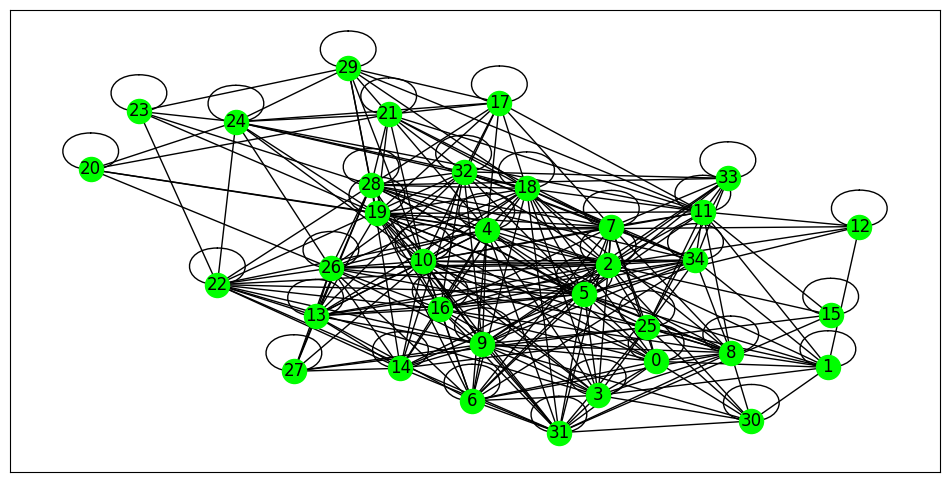

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 6))
networkx.draw_networkx(similarity_graph, node_color='lime')

In [20]:
scores = networkx.pagerank(similarity_graph)
ranked_sentences = sorted(((score, index) for index, score 
                                            in scores.items()), 
                          reverse=True)
ranked_sentences[:10]

[(0.037297049797214744, 2),
 (0.03490843547537588, 25),
 (0.034600868709236066, 4),
 (0.03240744530656925, 8),
 (0.03218748996523769, 28),
 (0.031836734268801445, 11),
 (0.031566658693076226, 26),
 (0.03150616293402057, 3),
 (0.031376143577383796, 5),
 (0.03112348153189422, 16)]

In [21]:
top_sentence_indices = [ranked_sentences[index][1] 
                        for index in range(num_sentences)]
top_sentence_indices.sort()

In [22]:
print('\n'.join(np.array(sentences)[top_sentence_indices]))

The game's main story revolves around the player character's quest to defeat Alduin the World-Eater, a dragon who is prophesied to destroy the world.
The game is set 200 years after the events of Oblivion and takes place in the fictional province of Skyrim.
Over the course of the game, the player completes quests and develops the character by improving skills.
The Elder Scrolls V: Skyrim is an action role-playing game, playable from either a first or third-person perspective.
The game's main quest can be completed or ignored at the player's preference after the first stage of the quest is finished.
Skyrim is the first entry in The Elder Scrolls to include dragons in the game's wilderness.
Like other creatures, dragons are generated randomly in the world and will engage in combat with NPCs, creatures and the player.
The player character can absorb the souls of dragons in order to use powerful spells called "dragon shouts" or "Thu'um".
